In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing
from IPython.display import clear_output

import time
import os
import json

In [2]:
from utils import show

In [ ]:
from model import *

In [4]:
idf = pd.read_csv("./data/artics.csv")
udf = pd.read_csv("./data/customs.csv")
edf = pd.read_csv("./data/trans.csv")

In [ ]:
item_enc = preprocessing.LabelEncoder()
item_enc.fit(idf.article_id.values)
user_enc = preprocessing.LabelEncoder()
user_enc.fit(udf.customer_id.values);

In [ ]:
snaps = list()
num_nodes_dict = {'user': udf.shape[0], 'item': idf.shape[0]}
for week_num in range(edf["week"].max()+1):
    snapdf = edf[edf.week <= week_num]
    data_dict = {
        ('user', 'ui', 'item'): 
            (torch.tensor(user_enc.transform(snapdf.customer_id), dtype=torch.int32), 
             torch.tensor(item_enc.transform(snapdf.article_id), dtype=torch.int32))
    }
    snaps.append(dgl.heterograph(data_dict, num_nodes_dict))

In [ ]:
sampler = dgl.dataloading.NeighborSampler([{('user', 'ui', 'item'): 10}], replace=True)
snapdataloaders = list()
for snap in snaps:    
    snapdataloader = dgl.dataloading.DataLoader(
        snap, 
        {"item": snap.nodes("item")}, 
        sampler,
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        num_workers=os.cpu_count()
    )
    snapdataloaders.append(snapdataloader)

In [ ]:
deltas = list()
num_nodes_dict = {'user': udf.shape[0], 'item': idf.shape[0]}
for week_num in range(edf["week"].max()+1):
    deltadf = edf[edf.week == week_num]
    data_dict = {
        ('item', "iu", 'user'): 
            (torch.tensor(item_enc.transform(deltadf.article_id), dtype=torch.int32),
             torch.tensor(user_enc.transform(deltadf.customer_id), dtype=torch.int32))
    }
    deltas.append(dgl.heterograph(data_dict, num_nodes_dict))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

In [ ]:
t_train = edf["week"].max() - 1
users_test_size = 3000
users_test_batch_size = 30000
users_test_inds_batch, users_test_inds, users_test_true = get_users_test(t_train, users_test_size, users_test_batch_size)

In [ ]:
epochs = 300
users_sample_size = int(udf.shape[0] * 1.0)
users_batch_size = 50000

gnn_in_size = 100
gnn_out_size = 100
rnn_in_size = 100
rnn_hid_size = 100
rnn_num_layers = 2
raw_feats_dim = 100

In [ ]:
model = HMModel_GAttN_MEAN_GRU_Att_DOT(gnn_in_size, gnn_out_size, rnn_in_size, rnn_hid_size, 
                                       rnn_num_layers, udf.shape[0], idf.shape[0], raw_feats_dim).to(device)
# model = HMModel_GAttN_MAX_GRU_Att_DOT(gnn_in_size, gnn_out_size, rnn_in_size, rnn_hid_size, 
#                                       rnn_num_layers, udf.shape[0], idf.shape[0], raw_feats_dim).to(device)
# model = HMModel_GAttN_Att_GRU_Att_DOT(gnn_in_size, gnn_out_size, rnn_in_size, rnn_hid_size, 
#                                       rnn_num_layers, udf.shape[0], idf.shape[0], raw_feats_dim).to(device)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
items_embs = torch.empty(idf.shape[0], gnn_out_size, device=device)
neg_sampler = dgl.dataloading.negative_sampler.GlobalUniform(1)

In [ ]:
train_loss_vals = list()
test_loss_vals = list()
test_metric_vals = list()
epoch = 1

In [ ]:
start_time = time.time()
for epoch in range(epoch, epochs+1):
    # train
    tik = time.time()
    train_loss_val = train(model, optimizer, t_train, snapdataloaders, 
                           deltas, items_embs, users_sample_size, users_batch_size, neg_sampler)
    train_loss_vals.append(train_loss_val)
    scheduler.step(train_loss_val)
    print(f"Epoch {epoch} completed in {time.time() - tik:.2f}s, Loss: {train_loss_val:.4f}")
    # test
    if epoch % 5 == 0:
        tik = time.time()
        test_loss_val = test(model, t_train, snapdataloaders, deltas, items_embs,
                             users_test_inds_batch, neg_sampler)
        test_metric_val = inference(model, t_train, snapdataloaders, deltas, 
                                    items_embs, users_test_inds, users_test_true, item_enc)
        test_loss_vals.append(test_loss_val)
        test_metric_vals.append(test_metric_val)
        print(f"Test completed in {time.time() - tik:.2f}s, Loss: {test_loss_val:.4f}, Metric: {test_metric_val:.6f}")
#     else:
#         test_loss_vals.append(test_loss_vals[-1] if len(test_loss_vals) else 0)
    # show
    show(epoch, epochs, train_loss_vals, test_loss_vals, test_metric_vals)
    clear_output(wait=True)
#print(f"Total training time: {time.time() - start_time:.2f}s")

### Results: 
Graph Attention Network -> [purchases pooling] -> GRU -> GRU output attention aggregator -> Dot product for link prediction

#### 1) Max purchases pooling

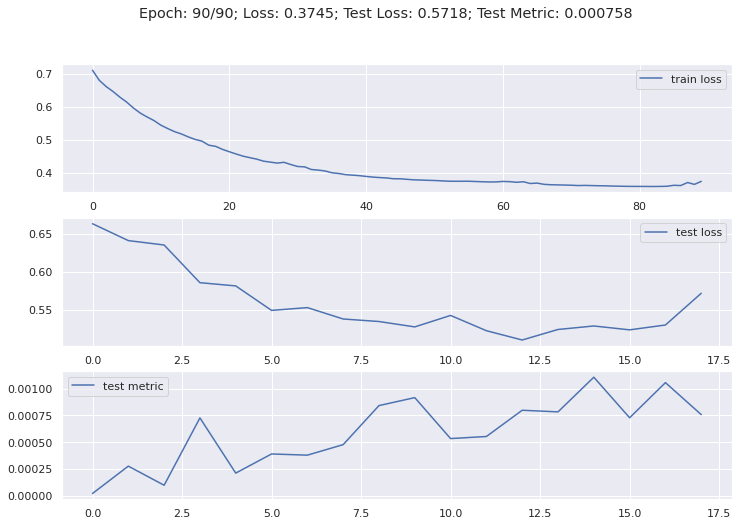

In [6]:
show(epoch, epochs, train_loss_vals, test_loss_vals, test_metric_vals)

Average epoch time: 7.5 sec

#### 2) Attention purchases pooling

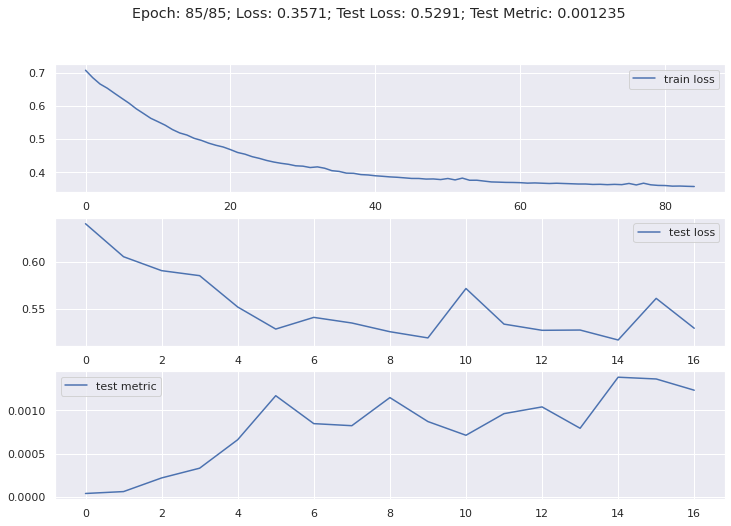

In [10]:
show(epoch, epochs, train_loss_vals, test_loss_vals, test_metric_vals)

Average epoch time: 13 sec